In [ ]:
# default_exp core

# Core XLA extensions

In [ ]:
#hide
#colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#hide_input
#colab
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
#hide
#colab
!curl -s https://course.fast.ai/setup/colab | bash 

Updating fastai...
Done.


### Setup torch XLA


In [ ]:
#hide_output
#colab
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4139  100  4139    0     0  72614      0 --:--:-- --:--:-- --:--:-- 72614
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
     |████████████████████████████████| 61kB 2.5MB/s 
Uninstalling torch-1.5.1+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                             

Install fastai2

In [ ]:
#hide_output
#colab
!pip install fastai2 --upgrade > /dev/null

In [ ]:
#hide
#colab
!pip install nbdev --upgrade > /dev/null

In [ ]:
#hide
#colab
%cd /content/drive/My\ Drive/fastai_xla_extensions

/content/drive/My Drive/fastai_xla_extensions


In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#exporti
from fastai2.optimizer import *

In [ ]:
#hide
from types import SimpleNamespace
def fake_opt_step(opt,barrier=False): opt.step()
xm = SimpleNamespace(optimizer_step=fake_opt_step)

In [ ]:
#colab
#exporti
import torch_xla.core.xla_model as xm

## XLA OptFunc Wrapper
Wraps the `opt_func` (which is a fastai function that creates an _Optimizer_) with a class such that calling the class returns a fastai `OptimWrapper` which has been monkeypatched to call the Pytorch-XLA function `xm.optimizer_step` which synchronizes the XLA graph.

In [ ]:
#export
class XLAOptFuncWrapper:
    def __init__(self, f):
        self.f = f 
    def __call__(self, *args, **kwargs):
        opt = self.f(*args, **kwargs)
        optim_wrapper = OptimWrapper(opt)
        def xla_step():
            xm.optimizer_step(opt, barrier=True)
        # monkeypatch optim_wrapper with xla_step
        optim_wrapper.step = xla_step
        return optim_wrapper
    

### Example: Create an MNIST classifier

Import fastai libraries 

In [ ]:
from fastai2.vision.all import *

Load data

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

Create datablock

In [ ]:
datablock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW),CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(),
    item_tfms=Resize(28),
    batch_tfms=[]
)

## Get TPU device

In [ ]:
#hide
tpu  = 'cpu'

In [ ]:
#colab
tpu = xm.xla_device()

Set dataloader to load the batches to the tpu

In [ ]:
dls = datablock.dataloaders(path, device=tpu)

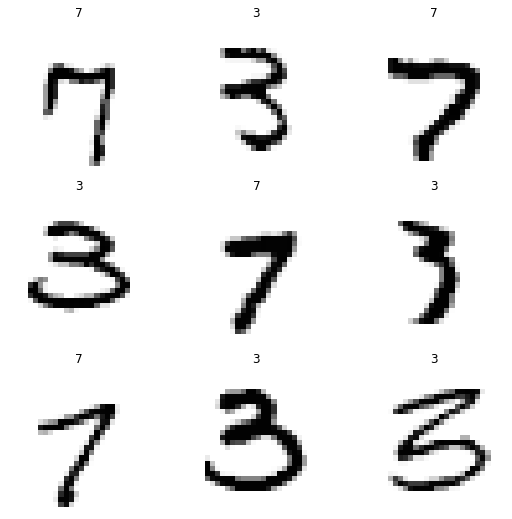

In [ ]:
dls.show_batch()

In [ ]:
xb,yb = dls.one_batch()
(xb.device, xb.shape)

(device(type='xla', index=1), torch.Size([64, 1, 28, 28]))

### Configure OptFunc
Wrap the opt_func with an XLA wrapper so that
the optimizer will call `xm.optimizer_step(opt)` instead of `opt.step` in the step method.

In [ ]:
XLAAdam = XLAOptFuncWrapper(Adam)

In [ ]:
learner = cnn_learner(dls, resnet18, metrics=accuracy, opt_func=XLAAdam)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
learner.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.107523,0.057359,0.982826,00:34


epoch,train_loss,valid_loss,accuracy,time
0,0.022053,0.003913,0.999019,00:31


In [ ]:
#hide
#ci
!nbdev_clean_nbs

In [ ]:
#hide
from nbdev.export import *
notebook2script()


Converted 00_core.ipynb.
Converted index.ipynb.


In [ ]:
#hide
!nbdev_build_docs

converting: /content/drive/My Drive/fastai_xla_extensions/nbs/index.ipynb
converting: /content/drive/My Drive/fastai_xla_extensions/nbs/00_core.ipynb
converting /content/drive/My Drive/fastai_xla_extensions/nbs/index.ipynb to README.md
